#### Notebook to create plots for doctoral thesis 

Coded in a way, that only first cell needs to be edited. Rest should be atomated.
Does calculations for a specific boundary condition and different parameter configurations: LFF and two MHS solutions. 
Need to edit:
- path to boundary condition data
- path to folder where plots are saved
- value choices for alpha and a


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import annotations
import numpy as np

from mflex.simulate.simulate_boundary import dalmatian

from mhsflex.field2d import Field2dData
from mhsflex.field3d import Field3dData, calculate_magfield
from mhsflex.vis import plot, plot_plasma_parameters
from mhsflex.metrics import compare_field3d

from matplotlib import rc, colors
import matplotlib.pyplot as plt


rc("font", **{"family": "serif", "serif": ["Times"]})
rc("text", usetex=True)

c4 = (1.000, 0.224, 0.376)
c1 = (0.439, 0.788, 1.000)
c3 = "black"
c2 = (0.420, 0.502, 1.000)

cmap = colors.LinearSegmentedColormap.from_list(
    "cmap",
    (
        (0.000, (0.000, 0.000, 0.000)),
        (0.500, (0.659, 0.659, 0.659)),
        (1.000, (1.000, 1.000, 1.000)),
    ),
)

cmap2 = colors.LinearSegmentedColormap.from_list(
    "cmap2", ((0.000, (0.984, 1.000, 0.000)), (1.000, (1.000, 0.988, 0.761)))
)

/Users/lilli/Library/Caches/pypoetry/virtualenvs/mflex-cNoQEf_u-py3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### For example from analytical expression

In [3]:
nresol_x = 200
nresol_y = 200
nresol_z = 400
xmin = 0.0
xmax = 2.0  # in units of 10^4 km, therefore corresponds to 20Mm
ymin = 0.0
ymax = 2.0
zmin = 0.0
zmax = 2.0
pixelsize_x = (xmax - xmin) / nresol_x
pixelsize_y = (ymax - ymin) / nresol_y
pixelsize_z = (zmax - zmin) / nresol_z

z0 = 0.2
deltaz = 0.02

z_arr = np.arange(nresol_z) * (zmax - zmin) / (nresol_z - 1) + zmin
x_arr = np.arange(nresol_x) * (xmax - xmin) / (nresol_x - 1) + xmin
y_arr = np.arange(nresol_y) * (ymax - ymin) / (nresol_y - 1) + ymin
B_PHOTO = 500
data_bz = np.zeros((nresol_y, nresol_x))

for ix in range(0, nresol_x):
    for iy in range(0, nresol_y):
        x = x_arr[ix]
        y = y_arr[iy]
        data_bz[iy, ix] = dalmatian(x, y) * B_PHOTO

data2d = Field2dData(
    nresol_x,
    nresol_y,
    nresol_z,
    nresol_x,
    pixelsize_x,
    pixelsize_y,
    pixelsize_z,
    x_arr,
    y_arr,
    z_arr,
    data_bz,
)

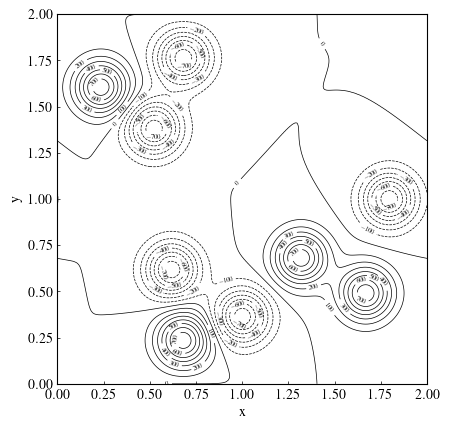

In [7]:
x_grid, y_grid = np.meshgrid(x_arr, y_arr)

fig = plt.figure()
ax = fig.add_subplot(111)
CS = ax.contour(
    x_grid,
    y_grid,
    data_bz,
    18,
    colors="k",
    linewidths=0.5,
)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.clabel(CS, fontsize=5, inline=True)
ax.set_box_aspect(1)
ax.tick_params(direction="in", length=2, width=0.5)
plotname = "/Users/lilli/Desktop/Thesis/multipole_contour.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()

In [9]:
from mhsflex.b3d import mirror

data_bz_see = mirror(data_bz)

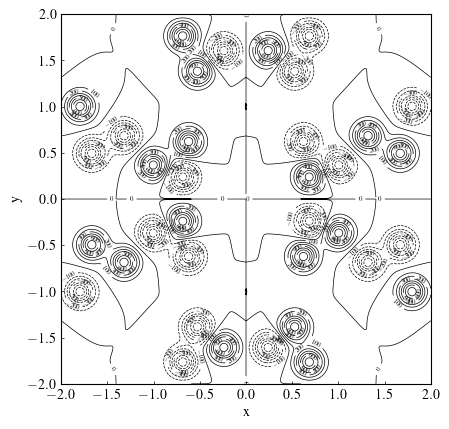

In [11]:
x_arr = np.arange(2*nresol_x) * (2 * xmax) / (2*nresol_x - 1) - xmax
y_arr = np.arange(2*nresol_y) * (2 * ymax) / (2*nresol_y - 1) - ymax

x_grid, y_grid = np.meshgrid(x_arr, y_arr)

fig = plt.figure()
ax = fig.add_subplot(111)
CS = ax.contour(
    x_grid,
    y_grid,
    data_bz_see,
    18,
    colors="k",
    linewidths=0.5,
)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.clabel(CS, fontsize=5, inline=True)
ax.set_box_aspect(1)
ax.tick_params(direction="in", length=2, width=0.5)
plotname = "/Users/lilli/Desktop/Thesis/multipole_contour_seehafer.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()

### SDO Example

In [ ]:
path = "/Users/lilli/Desktop/SOAR/obs/solo_L2_phi-hrt-blos_20220307T000609_V01.fits"
data2d = Field2dData.from_fits_SDO(path)

z0 = 2.0
deltaz = 0.2

### SOAR Example

In [ ]:
path = "/Users/lilli/Desktop/SOAR/obs/solo_L2_phi-hrt-blos_20220307T000609_V01.fits"
data2d = Field2dData.from_fits_SolOr(path)

z0 = 2.0
deltaz = 0.2

### Independent from here

In [15]:
# Background atmosphere parameters
b = 1.0

alphapot = 0.0
alpha = 0.5

alff = 0.0
amhs1 = 0.22
amhs2 = 0.44

data3d = calculate_magfield(data2d, amhs2, b, alpha, z0, deltaz)

In [16]:
data3d_2F1 = calculate_magfield(
    data2d, amhs2, b, alpha, z0, deltaz, asymptotic=False
)

In [19]:
compare_field3d(data3d_2F1, data3d)

MAGNETIC FIELD VECTOR METRICS
-----------------------------------------------------------------------------------------------------------
Vector correlation metric:  0.9999827044027552 (Reference value:  1.0 )
Cauchy-Schwarz metric:  0.9999986737651206 (Reference value:  1.0 )
Normalised vector error metric:  0.006006733578000474 (Reference value:  0.0 )
Mean vector error metric:  0.000940694147225841 (Reference value:  0.0 )
Magnetic energy metric:  1.0024081293904128 (Reference value:  1.0 )
-----------------------------------------------------------------------------------------------------------
FIELD LINE DIVERGENCE METRIC
-----------------------------------------------------------------------------------------------------------
Percentage of footpoints with error smaller than 10 percent of all closed fieldlines:  1.0


In [ ]:
# Calculate magnetic field data
data3dpot = calculate_magfield(data2d, alff, b, alphapot, z0, deltaz)
data3dlff = calculate_magfield(data2d, alff, b, alpha, z0, deltaz)
data3dmhs1 = calculate_magfield(data2d, amhs1, b, alpha, z0, deltaz)
data3dmhs2 = calculate_magfield(data2d, amhs2, b, alpha, z0, deltaz)

In [ ]:
path2saveP = "/Users/lilli/Desktop/mflex/multipole/P"
path2saveLFF = "/Users/lilli/Desktop/mflex/multipole/LFF"
path2saveMHS2 = "/Users/lilli/Desktop/mflex/multipole/MHS2"
path2saveMHS1 = "/Users/lilli/Desktop/mflex/multipole/MHS1"

data3dpot.save(path2saveP)
data3dlff.save(path2saveLFF)
data3dmhs1.save(path2saveMHS1)
data3dmhs2.save(path2saveMHS2)

In [ ]:
data3dlffrecon = Field3dData.load(path2save)

In [ ]:
folder = "/Users/lilli/Desktop/mflex/multipole/plots"

In [ ]:
plot(data3dlffrecon, "los", False, True, path=folder)
plot(data3dlffrecon, "side", False, True, path=folder)
plot(data3dlffrecon, "angular", False, True, path=folder)

In [ ]:
# Plot field lines

plot(data3dpot, "los", False, True, path=folder)
plot(data3dpot, "side", False, True, path=folder)
plot(data3dpot, "angular", False, True, path=folder)

plot(data3dlff, "los", False, True, path=folder)
plot(data3dlff, "side", False, True, path=folder)
plot(data3dlff, "angular", False, True, path=folder)

plot(data3dmhs1, "los", False, True, path=folder)
plot(data3dmhs1, "side", False, True, path=folder)
plot(data3dmhs1, "angular", False, True, path=folder)

plot(data3dmhs2, "los", False, True, path=folder)
plot(data3dmhs2, "side", False, True, path=folder)
plot(data3dmhs2, "angular", False, True, path=folder)

In [ ]:
data3dpot_2F1 = calculate_magfield(
    data2d, alff, b, alphapot, z0, deltaz, asymptotic=False
)
data3dlff_2F1 = calculate_magfield(data2d, alff, b, alpha, z0, deltaz, asymptotic=False)
data3dmhs1_2F1 = calculate_magfield(
    data2d, amhs1, b, alpha, z0, deltaz, asymptotic=False
)
data3dmhs2_2F1 = calculate_magfield(
    data2d, amhs2, b, alpha, z0, deltaz, asymptotic=False
)

In [ ]:
path2saveP_2F1 = "/Users/lilli/Desktop/mflex/multipole/P_2F1"
path2saveLFF_2F1 = "/Users/lilli/Desktop/mflex/multipole/LFF_2F1"
path2saveMHS2_2F1 = "/Users/lilli/Desktop/mflex/multipole/MHS2_2F1"
path2saveMHS1_2F1 = "/Users/lilli/Desktop/mflex/multipole/MHS1_2F1"

data3dpot_2F1.save(path2saveP_2F1)
data3dlff_2F1.save(path2saveLFF_2F1)
data3dmhs1_2F1.save(path2saveMHS1_2F1)
data3dmhs2_2F1.save(path2saveMHS2_2F1)

In [ ]:
folder2 = "/Users/lilli/Desktop/mflex/multipole/plots_2F1"

In [ ]:
plot(data3dpot_2F1, "los", False, True, path=folder2)
plot(data3dpot_2F1, "side", False, True, path=folder2)
plot(data3dpot_2F1, "angular", False, True, path=folder2)

plot(data3dlff_2F1, "los", False, True, path=folder2)
plot(data3dlff_2F1, "side", False, True, path=folder2)
plot(data3dlff_2F1, "angular", False, True, path=folder2)

plot(data3dmhs1_2F1, "los", False, True, path=folder2)
plot(data3dmhs1_2F1, "side", False, True, path=folder2)
plot(data3dmhs1_2F1, "angular", False, True, path=folder2)

plot(data3dmhs2_2F1, "los", False, True, path=folder2)
plot(data3dmhs2_2F1, "side", False, True, path=folder2)
plot(data3dmhs2_2F1, "angular", False, True, path=folder2)

In [10]:
folder3 = "/Users/lilli/Desktop/mflex/multipole"

In [ ]:
# Plot pressure and density where Bz is maximal on the photopshere

ix_max = np.unravel_index(data3dlff.bz.argmax(), data3dlff.bz.shape)[1]
iy_max = np.unravel_index(data3dlff.bz.argmax(), data3dlff.bz.shape)[0]

plt.plot(
    data3dlff.z,
    data3dlff.dpressure[iy_max, ix_max, :],
    linewidth=0.5,
    linestyle="solid",
    color=c3,
    label="LFF",
)
plt.plot(
    data3dmhs1.z,
    data3dmhs1.dpressure[iy_max, ix_max, :],
    linewidth=0.5,
    linestyle="solid",
    color=c2,
    label="MHS A",
)
plt.plot(
    data3dmhs1_2F1.z,
    data3dmhs1_2F1.dpressure[iy_max, ix_max, :],
    linewidth=0.5,
    linestyle="dashed",
    color=c2,
    label="MHS A N+W(19)",
)
plt.plot(
    data3dmhs2.z,
    data3dmhs2.dpressure[iy_max, ix_max, :],
    linewidth=0.5,
    linestyle="solid",
    color=c4,
    label="MHS B",
)
plt.plot(
    data3dmhs2_2F1.z,
    data3dmhs2_2F1.dpressure[iy_max, ix_max, :],
    linewidth=0.5,
    linestyle="dashed",
    color=c4,
    label="MHS B N+W(19)",
)
plt.ylabel(r"$\Delta p$")
plt.xlabel("z")
plt.xlim([0, 2 * z0])
plt.legend(frameon=False)
plt.tick_params(direction="in", length=2, width=0.5)
plotname = folder3 + "/dpres.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()

plt.plot(
    data3dlff.z,
    data3dlff.ddensity[iy_max, ix_max, :],
    linewidth=0.5,
    linestyle="solid",
    color=c3,
    label="LFF",
)
plt.plot(
    data3dmhs1.z,
    data3dmhs1.ddensity[iy_max, ix_max, :],
    linewidth=0.5,
    linestyle="solid",
    color=c2,
    label="MHS A",
)
plt.plot(
    data3dmhs1_2F1.z,
    data3dmhs1_2F1.ddensity[iy_max, ix_max, :],
    linewidth=0.5,
    linestyle="dashed",
    color=c2,
    label="MHS A N+W(19)",
)
plt.plot(
    data3dmhs2.z,
    data3dmhs2.ddensity[iy_max, ix_max, :],
    linewidth=0.5,
    linestyle="solid",
    color=c4,
    label="MHS B",
)
plt.plot(
    data3dmhs2_2F1.z,
    data3dmhs2_2F1.ddensity[iy_max, ix_max, :],
    linewidth=0.5,
    linestyle="dashed",
    color=c4,
    label="MHS B N+W(19)",
)
plt.ylabel(r"$\Delta \rho$")
plt.xlabel("z")
plt.legend(frameon=False)
plt.xlim([0, 2 * z0])
plt.tick_params(direction="in", length=2, width=0.5)
plotname = folder3 + "/dden.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()

plt.plot(
    data3dlff.z,
    data3dlff.fpressure[iy_max, ix_max, :],
    linewidth=0.5,
    linestyle="solid",
    color=c3,
    label="LFF",
)
plt.plot(
    data3dmhs1.z,
    data3dmhs1.fpressure[iy_max, ix_max, :],
    linewidth=0.5,
    linestyle="solid",
    color=c2,
    label="MHS A",
)
plt.plot(
    data3dmhs1_2F1.z,
    data3dmhs1_2F1.fpressure[iy_max, ix_max, :],
    linewidth=0.5,
    linestyle="dashed",
    color=c2,
    label="MHS A N+W(19)",
)
plt.plot(
    data3dmhs2.z,
    data3dmhs2.fpressure[iy_max, ix_max, :],
    linewidth=0.5,
    linestyle="solid",
    color=c4,
    label="MHS B",
)
plt.plot(
    data3dmhs2_2F1.z,
    data3dmhs2_2F1.fpressure[iy_max, ix_max, :],
    linewidth=0.5,
    linestyle="dashed",
    color=c4,
    label="MHS B N+W(19)",
)
plt.ylabel(r"$p$")
plt.xlabel("z")
plt.legend(frameon=False)
plt.xlim([0, 2 * z0])
plt.tick_params(direction="in", length=2, width=0.5)
plotname = folder3 + "/fpres.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()

plt.plot(
    data3dlff.z,
    data3dlff.fdensity[iy_max, ix_max, :],
    linewidth=0.5,
    linestyle="solid",
    color=c3,
    label="LFF",
)
plt.plot(
    data3dmhs1.z,
    data3dmhs1.fdensity[iy_max, ix_max, :],
    linewidth=0.5,
    linestyle="solid",
    color=c2,
    label="MHS A",
)
plt.plot(
    data3dmhs1_2F1.z,
    data3dmhs1_2F1.fdensity[iy_max, ix_max, :],
    linewidth=0.5,
    linestyle="dashed",
    color=c2,
    label="MHS A N+W(19)",
)
plt.plot(
    data3dmhs2.z,
    data3dmhs2.fdensity[iy_max, ix_max, :],
    linewidth=0.5,
    linestyle="solid",
    color=c4,
    label="MHS B",
)
plt.plot(
    data3dmhs2_2F1.z,
    data3dmhs2_2F1.fdensity[iy_max, ix_max, :],
    linewidth=0.5,
    linestyle="dashed",
    color=c4,
    label="MHS B N+W(19)",
)
plt.ylabel(r"$\rho$")
plt.xlabel("z")
plt.legend(frameon=False)
plt.xlim([0, 2 * z0])
plt.tick_params(direction="in", length=2, width=0.5)
plotname = folder3 + "/fden.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()

In [ ]:
plt.plot(
    data3dmhs1_2F1.z,
    data3dmhs1_2F1.dpressure[0, 0, :],
    linewidth=0.4,
    linestyle="solid",
    color=c4,
    alpha=0.5,
    label="High-a MHS",
)
plt.plot(
    data3dmhs1_2F1.z,
    data3dmhs2_2F1.dpressure[0, 0, :],
    linewidth=0.4,
    linestyle="solid",
    color=c2,
    alpha=0.5,
    label="Low-a MHS",
)
for ix in range(0, data3dmhs1.nx, 12):
    for iy in range(0, data3dmhs1.ny, 12):
        plt.plot(
            data3dmhs1_2F1.z,
            data3dmhs1_2F1.dpressure[iy, ix, :],
            linewidth=0.4,
            linestyle="solid",
            color=c4,
            alpha=0.5,
        )
        plt.plot(
            data3dmhs1_2F1.z,
            data3dmhs2_2F1.dpressure[iy, ix, :],
            linewidth=0.4,
            linestyle="solid",
            color=c2,
            alpha=0.5,
        )
plt.plot(
    data3dmhs1.z,
    data3dlff_2F1.dpressure[0, 0, :],
    linewidth=0.4,
    linestyle="solid",
    color="black",
    label="LLF",
)
plt.xlim([0, 2 * z0])
plt.ylabel(r"$\Delta p$")
plt.xlabel("z")
plt.legend(frameon=False)
plt.tick_params(direction="in", length=2, width=0.5)
plotname = folder2 + "/dpres.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()


plt.plot(
    data3dmhs1.z,
    data3dmhs1_2F1.ddensity[0, 0, :],
    linewidth=0.4,
    linestyle="solid",
    color=c4,
    alpha=0.5,
    label="High-a MHS",
)
plt.plot(
    data3dmhs1.z,
    data3dmhs2_2F1.ddensity[0, 0, :],
    linewidth=0.4,
    linestyle="solid",
    color=c2,
    alpha=0.5,
    label="Low-a MHS",
)
for ix in range(0, data3dmhs1.nx, 12):
    for iy in range(0, data3dmhs1.ny, 12):
        plt.plot(
            data3dmhs1.z,
            data3dmhs1_2F1.ddensity[iy, ix, :],
            linewidth=0.4,
            linestyle="solid",
            color=c4,
            alpha=0.5,
        )
        plt.plot(
            data3dmhs1.z,
            data3dmhs2_2F1.ddensity[iy, ix, :],
            linewidth=0.4,
            linestyle="solid",
            color=c2,
            alpha=0.5,
        )
plt.plot(
    data3dmhs1.z,
    data3dlff_2F1.ddensity[iy_max, ix_max, :],
    linewidth=0.4,
    linestyle="solid",
    color="black",
    label="LLF",
)
plt.xlim([0, 2 * z0])
plt.ylabel(r"$\Delta \rho$")
plt.xlabel("z")
plt.legend(frameon=False)
plt.tick_params(direction="in", length=2, width=0.5)
plotname = folder2 + "/dden.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()

### Metric caluclation and plotting

In [5]:
deltaz_arr = np.array((0.01, 0.02, 0.04, 0.1))

data3dlff_d1 = calculate_magfield(data2d, alff, b, alpha, z0, 0.01)
data3dlff_2F1_d1 = calculate_magfield(
    data2d, alff, b, alpha, z0, 0.01, asymptotic=False
)

data3dlff_d2 = calculate_magfield(data2d, alff, b, alpha, z0, 0.02)
data3dlff_2F1_d2 = calculate_magfield(
    data2d, alff, b, alpha, z0, 0.02, asymptotic=False
)

data3dlff_d3 = calculate_magfield(data2d, alff, b, alpha, z0, 0.04)
data3dlff_2F1_d3 = calculate_magfield(
    data2d, alff, b, alpha, z0, 0.04, asymptotic=False
)

data3dlff_d4 = calculate_magfield(data2d, alff, b, alpha, z0, 0.1)
data3dlff_2F1_d4 = calculate_magfield(data2d, alff, b, alpha, z0, 0.1, asymptotic=False)

In [ ]:
data3dmhs1_d1 = calculate_magfield(data2d, amhs1, b, alpha, z0, 0.01)
data3dmhs1_2F1_d1 = calculate_magfield(
    data2d, amhs1, b, alpha, z0, 0.01, asymptotic=False
)

data3dmhs1_d2 = calculate_magfield(data2d, amhs1, b, alpha, z0, 0.02)
data3dmhs1_2F1_d2 = calculate_magfield(
    data2d, amhs1, b, alpha, z0, 0.02, asymptotic=False
)

In [ ]:
data3dmhs1_d3 = calculate_magfield(data2d, amhs1, b, alpha, z0, 0.04)
data3dmhs1_2F1_d3 = calculate_magfield(
    data2d, amhs1, b, alpha, z0, 0.04, asymptotic=False
)

data3dmhs1_d4 = calculate_magfield(data2d, amhs1, b, alpha, z0, 0.1)
data3dmhs1_2F1_d4 = calculate_magfield(
    data2d, amhs1, b, alpha, z0, 0.1, asymptotic=False
)

In [ ]:
data3dmhs2_d1 = calculate_magfield(data2d, amhs2, b, alpha, z0, 0.01)
data3dmhs2_2F1_d1 = calculate_magfield(
    data2d, amhs2, b, alpha, z0, 0.01, asymptotic=False
)

data3dmhs2_d2 = calculate_magfield(data2d, amhs2, b, alpha, z0, 0.02)
data3dmhs2_2F1_d2 = calculate_magfield(
    data2d, amhs2, b, alpha, z0, 0.02, asymptotic=False
)

In [ ]:
data3dmhs2_d3 = calculate_magfield(data2d, amhs2, b, alpha, z0, 0.04)
data3dmhs2_2F1_d3 = calculate_magfield(
    data2d, amhs2, b, alpha, z0, 0.04, asymptotic=False
)

data3dmhs2_d4 = calculate_magfield(data2d, amhs2, b, alpha, z0, 0.1)
data3dmhs2_2F1_d4 = calculate_magfield(
    data2d, amhs2, b, alpha, z0, 0.1, asymptotic=False
)

### LFF

In [6]:
print("Delta z 1")
(
    VC_lff_d1,
    CS_lff_d1,
    NE_lff_d1,
    ME_lff_d1,
    MAGE_lff_d1,
) = compare_field3d(data3dlff_2F1_d1, data3dlff_d1)

print("Delta z 2")

    VC_lff_d2,
    CS_lff_d2,
    NE_lff_d2,
    ME_lff_d2,
    MAGE_lff_d2,
) = compare_field3d(data3dlff_2F1_d2, data3dlff_d2)

print("Delta z 3")
(
    VC_lff_d3,
    CS_lff_d3,
    NE_lff_d3,
    ME_lff_d3,
    MAGE_lff_d3,
) = compare_field3d(data3dlff_2F1_d3, data3dlff_d3)

print("Delta z 4")
(
    VC_lff_d4,
    CS_lff_d4,
    NE_lff_d4,
    ME_lff_d4,
    MAGE_lff_d4,
) = compare_field3d(data3dlff_2F1_d4, data3dlff_d4)

Delta z 1
MAGNETIC FIELD VECTOR METRICS
-----------------------------------------------------------------------------------------------------------
Vector correlation metric:  0.9999999999999998 (Reference value:  1.0 )
Cauchy-Schwarz metric:  1.0 (Reference value:  1.0 )
Normalised vector error metric:  3.143628289120954e-16 (Reference value:  0.0 )
Mean vector error metric:  3.5560529071964683e-16 (Reference value:  0.0 )
Magnetic energy metric:  0.9999999999999997 (Reference value:  1.0 )
Delta z 2
MAGNETIC FIELD VECTOR METRICS
-----------------------------------------------------------------------------------------------------------
Vector correlation metric:  1.0 (Reference value:  1.0 )
Cauchy-Schwarz metric:  1.0 (Reference value:  1.0 )
Normalised vector error metric:  3.13028544619324e-16 (Reference value:  0.0 )
Mean vector error metric:  3.946872911017815e-16 (Reference value:  0.0 )
Magnetic energy metric:  1.0 (Reference value:  1.0 )
Delta z 3
MAGNETIC FIELD VECTOR METRIC

### MHS 1

In [ ]:
print("Delta z 1")
VC_mhs1_d1, CS_mhs1_d1, NE_mhs1_d1, ME_mhs1_d1, MAGE_mhs1_d1 = compare_field3d(
    data3dmhs1_2F1_d1, data3dmhs1_d1
)

print("Delta z 2")
VC_mhs1_d2, CS_mhs1_d2, NE_mhs1_d2, ME_mhs1_d2, MAGE_mhs1_d2 = compare_field3d(
    data3dmhs1_2F1_d2, data3dmhs1_d2
)

print("Delta z 3")
VC_mhs1_d3, CS_mhs1_d3, NE_mhs1_d3, ME_mhs1_d3, MAGE_mhs1_d3 = compare_field3d(
    data3dmhs1_2F1_d3, data3dmhs1_d3
)

print("Delta z 4")
VC_mhs1_d4, CS_mhs1_d4, NE_mhs1_d4, ME_mhs1_d4, MAGE_mhs1_d4 = compare_field3d(
    data3dmhs1_2F1_d4, data3dmhs1_d4
)

### MHS 2

In [ ]:
print("Delta z 1")
(
    VC_mhs2_d1,
    CS_mhs2_d1,
    NE_mhs2_d1,
    ME_mhs2_d1,
    MAGE_mhs2_d1,
) = compare_field3d(data3dmhs2_2F1_d1, data3dmhs2_d1)

print("Delta z 2")
(
    VC_mhs2_d2,
    CS_mhs2_d2,
    NE_mhs2_d2,
    ME_mhs2_d2,
    MAGE_mhs2_d2,
) = compare_field3d(data3dmhs2_2F1_d2, data3dmhs2_d2)

print("Delta z 3")
(
    VC_mhs2_d3,
    CS_mhs2_d3,
    NE_mhs2_d3,
    ME_mhs2_d3,
    MAGE_mhs2_d3,
) = compare_field3d(data3dmhs2_2F1_d3, data3dmhs2_d3)

print("Delta z 4")
(
    VC_mhs2_d4,
    CS_mhs2_d4,
    NE_mhs2_d4,
    ME_mhs2_d4,
    MAGE_mhs2_d4,
) = compare_field3d(data3dmhs2_2F1_d4, data3dmhs2_d4)

In [4]:
deltaz_arr = np.array((0.01, 0.02, 0.04, 0.1))

VC_arr_mhs1 = np.array((0.999999774, 0.999998235, 0.999985683, 0.999812834))

CS_arr_mhs1 = np.array((0.999999966, 0.999999758, 0.999998289, 0.999982493))

VC_arr_mhs2 = np.array((0.999997982, 0.999982704, 0.999850308, 0.99817562))

CS_arr_mhs2 = np.array((0.999997982, 0.999998674, 0.999989079, 0.999882478))

MagEn_arr_mhs2 = np.array((1.000640366, 1.002408129, 1.008643495, 1.034597151))

MagEn_arr_mhs1 = np.array((1.000065601, 1.000245603, 1.000914789, 1.004008276))

NErr_arr_mhs1 = np.array((0.000672715, 0.001883183, 0.005371777, 0.019470255))

MErr_arr_mhs1 = np.array((0.00010141, 0.00037741, 0.001363735, 0.00684037))

NErr_arr_mhs2 = np.array((0.002034516, 0.006006734, 0.017868199, 0.063289141))

MErr_arr_mhs2 = np.array((0.000255897, 0.000940694, 0.003307214, 0.01550478))

In [6]:
c5 = (1.000, 0.000, 0.773)


c6 = (1.000, 0.780, 0.000)
c7 = (0.443, 1.000, 0.855)
c8 = (0.996, 1.000, 0.000)

c9 = (0.671, 0.714, 1.000)

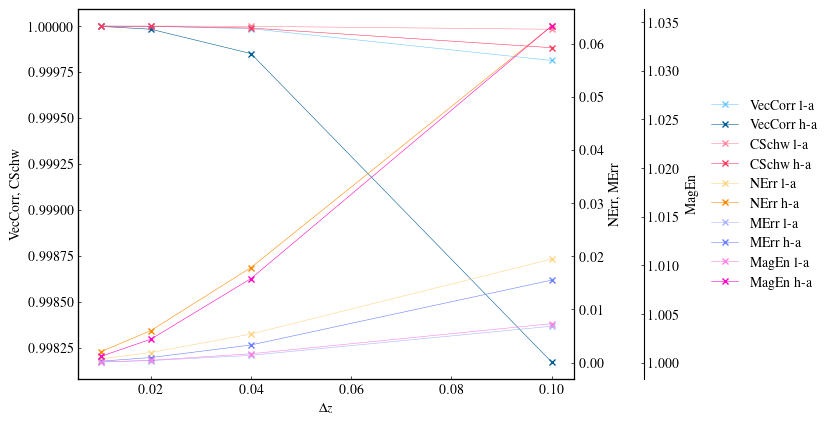

In [11]:
fig, ax1 = plt.subplots()

ax1.plot(
    deltaz_arr,
    VC_arr_mhs1,
    "-x",
    markersize=4,
    linewidth=0.4,
    color=c1,
    label="VecCorr l-a",
)
ax1.plot(
    deltaz_arr,
    VC_arr_mhs2,
    "-x",
    markersize=4,
    linewidth=0.4,
    color=(0.000, 0.365, 0.580),
    label="VecCorr h-a",
)

ax1.plot(
    deltaz_arr,
    CS_arr_mhs1,
    "-x",
    markersize=4,
    linewidth=0.4,
    color=(1.000, 0.533, 0.627),
    label="CSchw l-a",
)
ax1.plot(
    deltaz_arr,
    CS_arr_mhs2,
    "-x",
    markersize=4,
    linewidth=0.4,
    color=c4,
    label="CSchw h-a",
)


ax1.set_ylabel("VecCorr, CSchw")

ax1.set_xlabel(r"$\Delta z$")

ax2 = ax1.twinx()

ax2.plot(
    deltaz_arr,
    NErr_arr_mhs1,
    "-x",
    markersize=4,
    linewidth=0.4,
    color=(1.000, 0.831, 0.514),
    label="NErr l-a",
)
ax2.plot(
    deltaz_arr,
    NErr_arr_mhs2,
    "-x",
    markersize=4,
    linewidth=0.4,
    color=(1.000, 0.537, 0.000),
    label="NErr h-a",
)

ax2.plot(
    deltaz_arr,
    MErr_arr_mhs1,
    "-x",
    markersize=4,
    linewidth=0.4,
    color=c9 ,
    label="MErr l-a",
)
ax2.plot(
    deltaz_arr,
    MErr_arr_mhs2,
    "-x",
    markersize=4,
    linewidth=0.4,
    color=c2,
    label="MErr h-a",
)

ax2.set_ylabel("NErr, MErr")

ax3 = ax1.twinx()

ax3.plot(
    deltaz_arr,
    MagEn_arr_mhs1,
    "-x",
    markersize=4,
    linewidth=0.4,
    color=(1.000, 0.514, 0.890),
    label="MagEn l-a",
)
ax3.plot(
    deltaz_arr,
    MagEn_arr_mhs2,
    "-x",
    markersize=4,
    linewidth=0.4,
    color=c5,
    label="MagEn h-a",
)
ax3.spines["right"].set_position(("outward", 50))

ax3.set_ylabel("MagEn")
# ax1.legend(frameon=False, loc='center left', bbox_to_anchor=(1.1, 0.8))
# ax2.legend(frameon=False, loc ='center left', bbox_to_anchor=(1.1, 0.55))
# ax3.legend(frameon=False, loc ='center left', bbox_to_anchor=(1.1, 0.35))

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
lines = lines1 + lines2 + lines3
labels = labels1 + labels2 + labels3
plt.legend(lines, labels, frameon=False, loc="center left", bbox_to_anchor=(1.25, 0.5))

ax1.tick_params(direction="in", length=2, width=0.5)
ax2.tick_params(direction="in", length=2, width=0.5)
ax3.tick_params(direction="in", length=2, width=0.5)
plotname = folder3 + "/metrics.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()